In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook, load_workbook
from openpyxl.utils import get_column_letter
from datetime import datetime, timedelta, date
import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# RAW DATA SLB

In [3]:
#SAP_raw = pd.read_excel(r'C:\Users\USUARIO\Downloads\Raw data Jan 18th.xlsx', sheet_name='Sap', parse_dates=True, 
#date_parser= (lambda x :pd.to_datetime(x, format='%m/%d/%Y ')))

In [4]:
#SAP_raw = SAP_raw[['Field Purchase Order','Field PO Item','Material Number','Field PO Vendor','Field PO Date','Field PO Request Date(RDD)','HUB SO Process Class','Field PO GR Date']]

In [5]:
#SAP_raw.info()

In [6]:
Gold_data = pd.read_csv(r'C:\Users\USUARIO\Downloads\Gold Data.csv', index_col=0, encoding='latin-1', parse_dates=True)

In [7]:
Gold_data = Gold_data.reset_index()

In [8]:
Gold_data = Gold_data[['Field Purchase Order','Field PO Item','Material Number','Field PO Vendor','HUB SO Process Class','Field PO Date','Field PO Request Date(RDD)','OBS Creation Date HUB','ETA','Field PO GR Date']]

In [9]:
Gold_data['Field PO Date'] = pd.to_datetime(Gold_data['Field PO Date']).values
Gold_data['Field PO Request Date(RDD)'] = pd.to_datetime(Gold_data['Field PO Request Date(RDD)']).values
Gold_data['OBS Creation Date HUB'] = pd.to_datetime(Gold_data['OBS Creation Date HUB']).values
Gold_data['Field PO GR Date'] = pd.to_datetime(Gold_data['Field PO GR Date']).values

In [10]:
Gold_data[['Field Purchase Order','Field PO Item']] = Gold_data[['Field Purchase Order','Field PO Item']].astype(str)

#### GOLD GRs

In [11]:
Gold_GRs = Gold_data[Gold_data['Field PO GR Date'].notnull()]
Gold_GRs = Gold_data[Gold_data['Field PO Date'] > '2022-01-01']

In [12]:
Gold_GRs.head(3)

,Field Purchase Order,Field PO Item,Material Number,Field PO Vendor,HUB SO Process Class,Field PO Date,Field PO Request Date(RDD),OBS Creation Date HUB,ETA,Field PO GR Date
1278,4581174664,1,100860406,P9024,BO,2022-01-04,2022-07-31,2022-07-12,30-Jul-22,2022-08-06
1279,4581174664,1,100860406,P9024,BO,2022-01-04,2022-07-31,2022-07-12,30-Jul-22,2022-08-06
1280,4581174665,2,100006697,P9024,BO,2022-01-04,2022-12-25,2022-12-05,3-Jan-23,2023-01-07


In [13]:
Gold_GRs.drop(['Field PO Request Date(RDD)','ETA'], axis=1, inplace=True)

In [14]:
Gold_GRs.dropna(axis=0, inplace=True)

In [15]:
Gold_GRs['hub_time_d'] = Gold_GRs['OBS Creation Date HUB'] - Gold_GRs['Field PO Date']
Gold_GRs['lead_time_d'] = Gold_GRs['Field PO GR Date'] - Gold_GRs['Field PO Date'] 

In [16]:
Gold_GRs['hub_time_d'] = Gold_GRs.hub_time_d.dt.days
Gold_GRs['lead_time_d'] = Gold_GRs.lead_time_d.dt.days

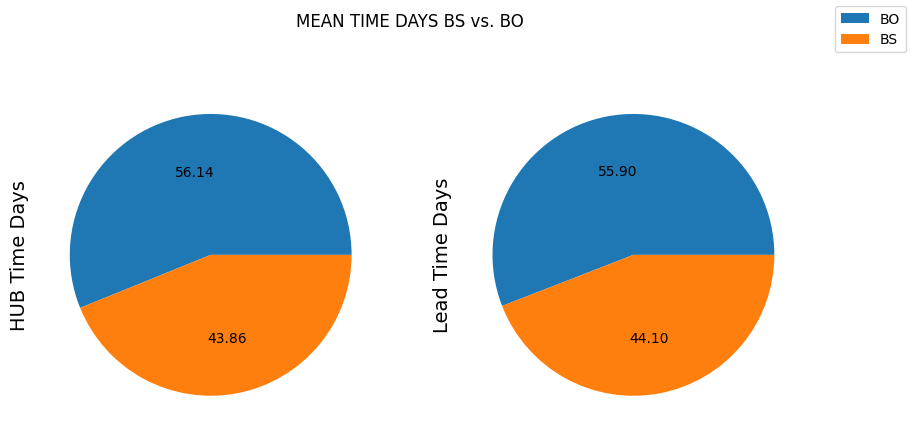

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.pie(Gold_GRs.groupby(by=['HUB SO Process Class']).mean()['hub_time_d'], autopct='%.2f')
ax2.pie(Gold_GRs.groupby(by=['HUB SO Process Class']).mean()['lead_time_d'], autopct='%.2f')

ax1.set_ylabel('HUB Time Days', fontsize=14)
ax2.set_ylabel('Lead Time Days', fontsize=14)

fig.legend(Gold_GRs['HUB SO Process Class'].unique())
fig.suptitle('MEAN TIME DAYS BS vs. BO')

plt.show()

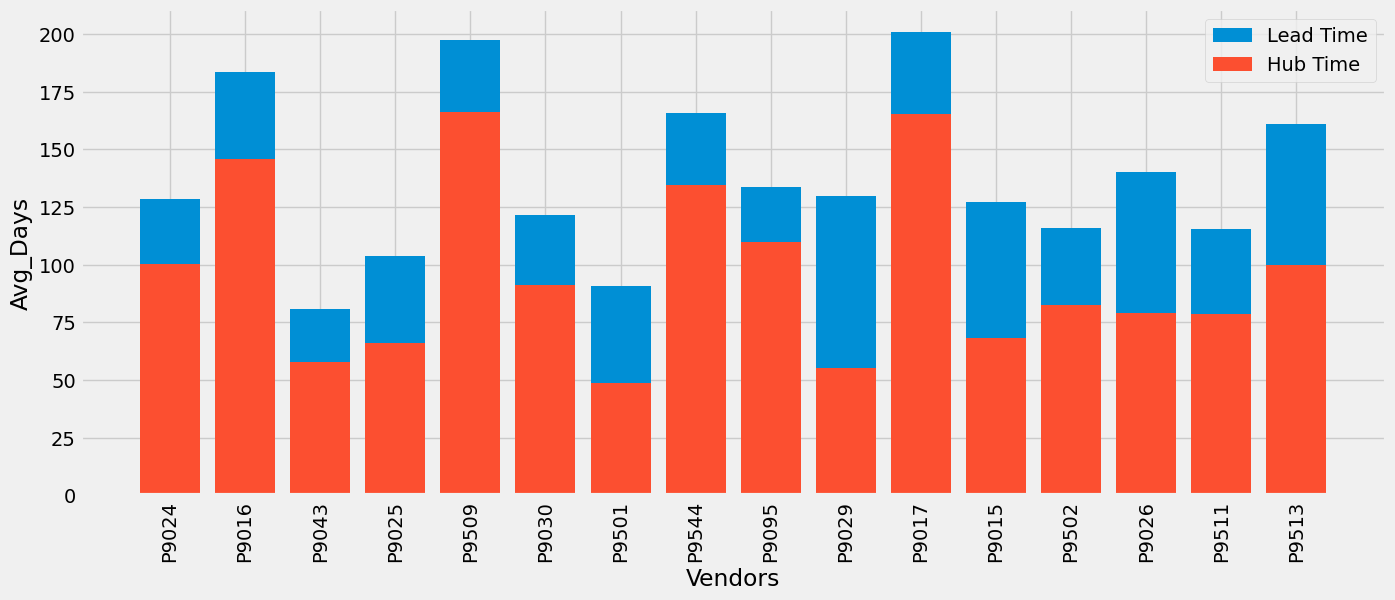

In [18]:
x = Gold_GRs['Field PO Vendor'].unique()

plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,6))
p1 = plt.bar(x, Gold_GRs.groupby(by='Field PO Vendor').mean()['lead_time_d'])
p2 = plt.bar(x, Gold_GRs.groupby(by='Field PO Vendor').mean()['hub_time_d'])
plt.xlabel("Vendors")
plt.ylabel("Avg_Days")
plt.xticks(rotation=90)
plt.legend((p1[0],p2[0]), ('Lead Time', 'Hub Time'))
plt.show()

### No ETA POs

In [56]:
POs_no_ETA = Gold_data.drop(['OBS Creation Date HUB', 'Field PO Request Date(RDD)'], axis=1)

In [57]:
POs_no_ETA = POs_no_ETA[POs_no_ETA['Field PO GR Date'].isna()]
POs_no_ETA = POs_no_ETA[POs_no_ETA['ETA'].isna()]

In [58]:
POs_no_ETA['current_date'] = pd.to_datetime(date.today())
POs_no_ETA.drop(['ETA', 'Field PO GR Date'], axis=1, inplace=True)

In [59]:
POs_no_ETA['elapsed_time'] = POs_no_ETA.current_date - POs_no_ETA['Field PO Date']

In [60]:
POs_no_ETA['elap_time_days'] = POs_no_ETA.elapsed_time.dt.days

In [24]:
#POs_no_ETA =  POs_no_ETA[POs_no_ETA['Field PO Date'] > '2022-01-01']

In [25]:
values = round(POs_no_ETA.groupby(by=['Field PO Vendor']).mean()['elap_time_days'],2)

df = POs_no_ETA.groupby(by=['Field PO Vendor']).count().reset_index()
df = df.rename({'Field Purchase Order':'numPOs'}, axis=1)

fig = px.treemap(df, path=[px.Constant("All POs"), 'Field PO Vendor',round(POs_no_ETA.groupby(by=['Field PO Vendor']).count()['elap_time_days'],2)], 
                 values=values, color_continuous_scale='RdBu', color='numPOs')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.data[0].textinfo='label+value'
fig.show()

In [26]:
delayed_POs = 180
fig = px.histogram(POs_no_ETA[POs_no_ETA.elap_time_days > delayed_POs], x='elap_time_days', color='Field PO Vendor', nbins=16, text_auto=True)
fig.update_traces(opacity=0.9)
fig.update_layout(title_text='NO ETA OPEN ORDERS BY DAY RANGES', xaxis_title_text='Elapsed_days', yaxis_title_text='Number_POs', bargap=0.08)
fig.show()

### ETA POs

In [27]:
ETA_POs = Gold_data.drop(['Field PO Request Date(RDD)','OBS Creation Date HUB', 'Field PO GR Date'], axis=1)
ETA_POs = ETA_POs[(ETA_POs.ETA.notna())]
ETA_POs = ETA_POs[ETA_POs['Field PO Date']> '2022-01-01']

In [28]:
ETA_POs = ETA_POs[~(ETA_POs['ETA'] == datetime.strptime('00:00:00', '%H:%M:%S').time())]

In [29]:
ETA_POs = ETA_POs[~(ETA_POs.ETA == '0-Jan-00')]

In [30]:
ETA_POs.ETA = pd.to_datetime(ETA_POs.ETA)

In [31]:
ETA_POs['time_ETA'] = ETA_POs.ETA - ETA_POs['Field PO Date']

In [32]:
ETA_POs.time_ETA = ETA_POs.time_ETA.dt.days

In [33]:
ETA_POs =  ETA_POs[ETA_POs.time_ETA > delayed_POs]

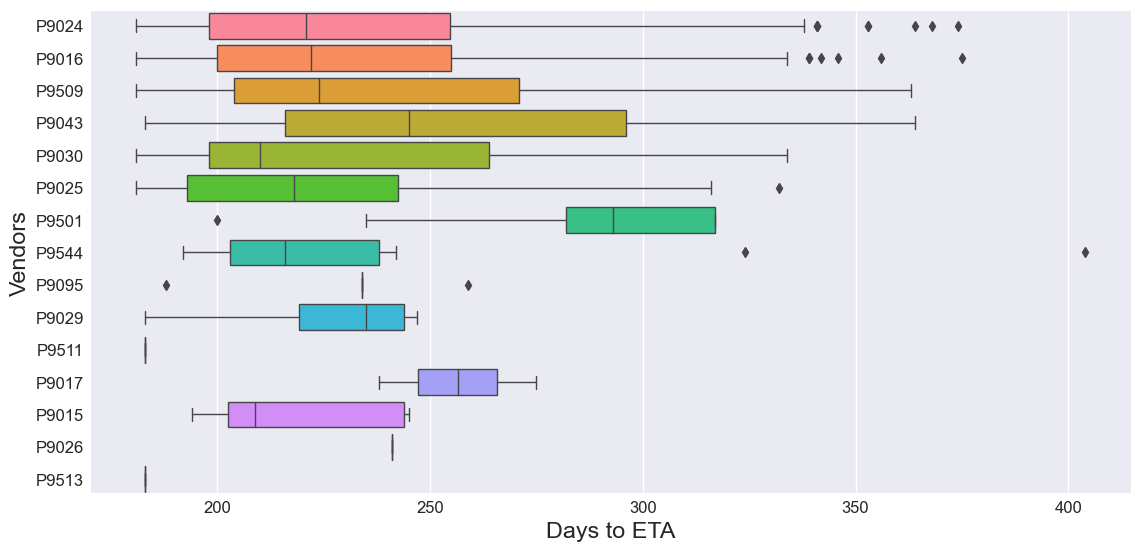

In [34]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
sns.boxplot(y=ETA_POs['Field PO Vendor'], x=ETA_POs.time_ETA, linewidth=1, saturation=5)
plt.ylabel("Vendors")
plt.xlabel("Days to ETA")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### GRs, No_ETA, ETA POs Comparisson

In [35]:
GRs = Gold_GRs.groupby(by='Field PO Vendor').mean()
No_ETA = POs_no_ETA.groupby(by='Field PO Vendor').mean()
ETA =  ETA_POs.groupby(by='Field PO Vendor').mean()

In [36]:
AVG_POs_time = (GRs.reset_index().merge(No_ETA, how='inner', on='Field PO Vendor')).merge(ETA, how='inner', on='Field PO Vendor')

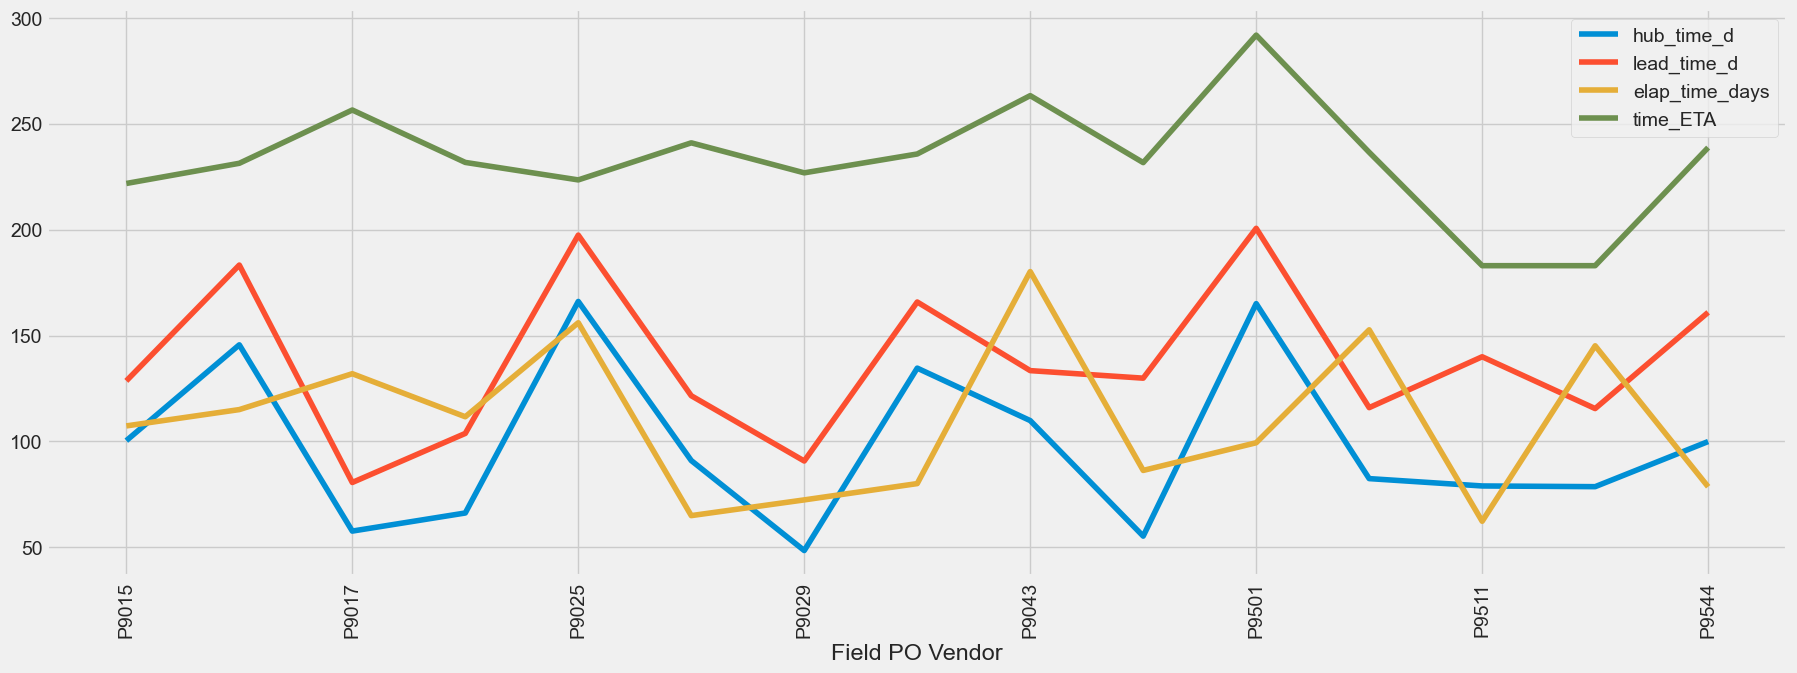

In [37]:
plt.style.use('fivethirtyeight')
AVG_POs_time.set_index('Field PO Vendor').plot(figsize=(20,7), kind='line',rot=90, use_index=True);

In [38]:
POs_no_ETA[(POs_no_ETA['Field PO Vendor'] == 'P9024')][POs_no_ETA.elap_time_days > AVG_POs_time[AVG_POs_time['Field PO Vendor'] == 'P9024']['time_ETA'].values[0]]

,Field Purchase Order,Field PO Item,Material Number,Field PO Vendor,HUB SO Process Class,Field PO Date,current_date,elapsed_time,elap_time_days
1380,4581192386,1,415382000,P9024,BO,2022-01-14,2023-02-10,392 days,392
1465,4581202172,1,101548467,P9024,BO,2022-01-20,2023-02-10,386 days,386
1466,4581202172,2,101552049,P9024,BO,2022-01-20,2023-02-10,386 days,386
1474,4581210246,35,700.BV.523_GSE,P9024,BO,2022-01-25,2023-02-10,381 days,381
1496,4581223671,2,H304464,P9024,BO,2022-02-01,2023-02-10,374 days,374
...,...,...,...,...,...,...,...,...,...
11348,4791119554,1,102402495,P9024,BO,2022-06-19,2023-02-10,236 days,236
11349,4791119582,1,102402496,P9024,BO,2022-06-19,2023-02-10,236 days,236
11350,4791119585,1,102467333,P9024,BO,2022-06-19,2023-02-10,236 days,236
11351,4791119600,1,102402549,P9024,BO,2022-06-19,2023-02-10,236 days,236


In [63]:
POs_no_ETA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3735 entries, 0 to 12942
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   Field Purchase Order  3735 non-null   object         
 1   Field PO Item         3735 non-null   object         
 2   Material Number       3735 non-null   object         
 3   Field PO Vendor       3734 non-null   object         
 4   HUB SO Process Class  3735 non-null   object         
 5   Field PO Date         3735 non-null   datetime64[ns] 
 6   current_date          3735 non-null   datetime64[ns] 
 7   elapsed_time          3735 non-null   timedelta64[ns]
 8   elap_time_days        3735 non-null   int64          
dtypes: datetime64[ns](2), int64(1), object(5), timedelta64[ns](1)
memory usage: 291.8+ KB
